In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

from sklearn.datasets import make_classification

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [15]:
path = './traces_core'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T-200_C-4-*.prof*")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)
    print(filename)

df = pd.concat(li, axis=0, ignore_index=True)


./traces_core/dpotrf_T-200_C-4-1.prof.h5
./traces_core/dpotrf_T-200_C-4-0.prof.h5


In [16]:
print(len(li))

2


# Clean the data

In [17]:
df = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df = df.astype(float)

In [18]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [19]:

filter = ( (df['task_class_id'] >= 0 ) & ( df['task_class_id'] <= 3 ) & ( df['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df = df[filter]
df.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
29700,310724.0,1872990.0,2.0,1.0,0.0,2.0,320000.0,0.0,1562.266
29701,1882105.0,2155457.0,2.0,1.0,0.0,2.0,320000.0,0.0,273.352
29702,2160874.0,2337577.0,2.0,2.0,0.0,1.0,320000.0,0.0,176.703
29703,2343376.0,3115221.0,2.0,1.0,0.0,2.0,320000.0,0.0,771.845
29704,3121080.0,3788875.0,2.0,2.0,0.0,1.0,320000.0,0.0,667.795


## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [20]:
df[df['task_class_id'] == 3].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
30333,1.512445e+09,1.518556e+09,4.0,3.0,0.0,3.0,960000.0,858539.0,6110.950
30336,1.519827e+09,1.520421e+09,4.0,3.0,0.0,3.0,960000.0,833470.0,593.685
30338,1.521034e+09,1.521575e+09,4.0,3.0,0.0,3.0,960000.0,832306.0,541.805
30341,1.522415e+09,1.522997e+09,4.0,3.0,0.0,3.0,960000.0,781526.0,582.162
30342,1.523016e+09,1.523552e+09,4.0,3.0,0.0,3.0,960000.0,781520.0,535.939


In [21]:
df.reset_index(inplace=True)

----------------- dpotrf [before] -------------------------- 
Min = 275.76
Max = 10258.279
Avg = 424.0763333333332
Std = 1037.9022100236655
----------------- dpotrf [after] -------------------------- 
Min = 282.661
Max = 320.419
Avg = 300.8730912698414
Std = 7.151284928673927
datapoints removed 16.0%
----------------- dtrsm [before] -------------------------- 
Min = 255.5
Max = 96195.164
Avg = 916.1540158922598
Std = 2607.750700226255
----------------- dtrsm [after] -------------------------- 
Min = 255.5
Max = 967.3820000000001
Avg = 446.24938718173905
Std = 149.28209659567617
datapoints removed 4.124579124579125%
----------------- dsyrk [before] -------------------------- 
Min = 171.171
Max = 106737.344
Avg = 865.7905070627079
Std = 2544.4307992431363
----------------- dsyrk [after] -------------------------- 
Min = 351.201
Max = 497.334
Avg = 420.4309775788068
Std = 27.281250870396676
datapoints removed 10.798679867986799%
----------------- dgemm [before] -------------------------- 

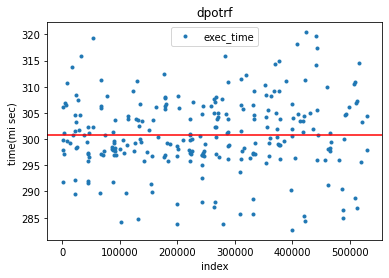

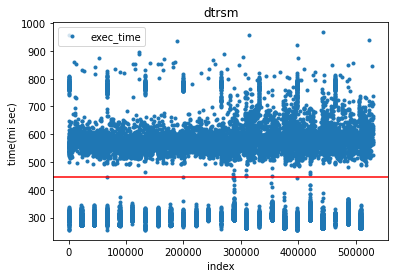

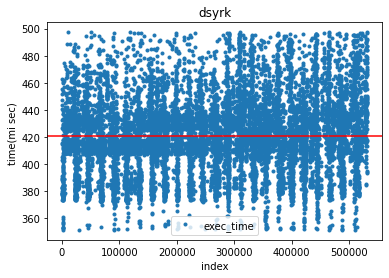

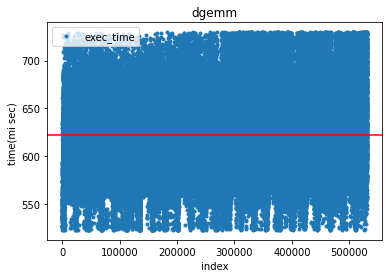

In [22]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    print('----------------- ' + df_class_name[i] + ' [before] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint1 = df_refined.shape[0]
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    print('----------------- ' + df_class_name[i] + ' [after] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint2 = df_refined.shape[0]
    
    perc_of_data = (datapoint1 - datapoint2) / datapoint1 * 100
    print('datapoints removed ' + str(perc_of_data) + '%')
    
    ax = df_refined.plot(y='exec_time',  use_index=True,
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i])
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    plt.savefig(df_class_name[i]+'_cloud', dpi=300)
    
    

## K-means

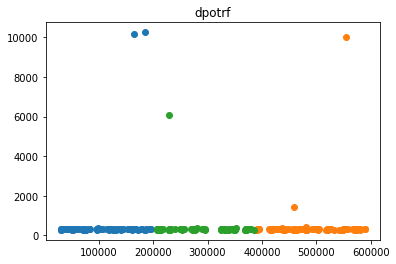

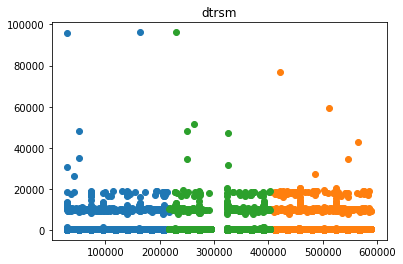

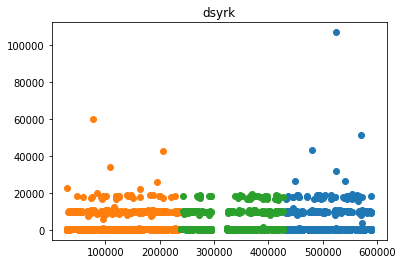

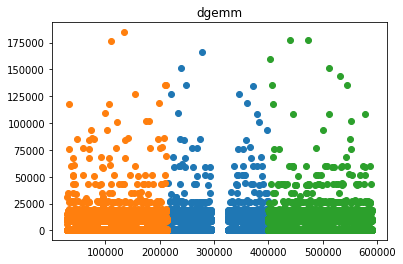

In [23]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    # define dataset
    df_exaxmple = df
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    x = df_refined[['index', 'exec_time']].copy()
    X = x.to_numpy()
    # define the model
    model = KMeans(n_clusters=3)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        pyplot.title(df_class_name[i])
    # show the plot
    pyplot.show()

## Reorder

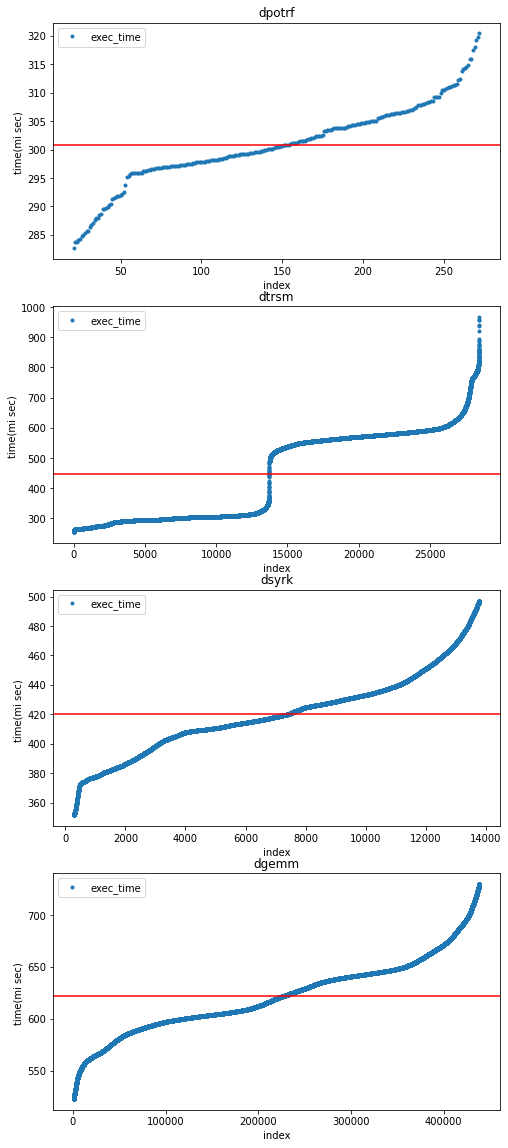

In [26]:
task_class_id = [0,1,2,3]
fig, axs = plt.subplots(4)
for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    df_refined = df_refined.sort_values('exec_time', axis=0, ascending=True, 
                                        inplace=False, kind='quicksort', na_position='last')
    df_refined.insert(0, 'new_index', range(0, len(df_refined)))
    
    #print(df_refined.head())
    
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    
    
    ax = df_refined.plot(y='exec_time',  x='new_index',
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i], ax=axs[i], figsize=(8, 20))
    
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    #plt.savefig(df_class_name[i]+'_reorder', dpi=300)
plt.savefig('reorder_core_4', dpi=300)    
    
    


